In [1]:
import pickle as pkl
import datashader as ds

/home/acosi/anaconda2/envs/py3/lib/python3.6/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [186]:
d = pkl.load(open('X_and_y.pkl','rb'))
df = d['features']
y = d['targets']
df['dependent_variable'] = y
df = df.astype(int)

In [187]:
mean_by_category = df.groupby(by='dependent_variable').mean().T
mean_by_category.index.name = 'words'
mean_by_category.columns = ['mean_when_y_is_zero', 'mean_when_y_is_one']
mean_by_category['difference'] = mean_by_category['mean_when_y_is_one']-mean_by_category['mean_when_y_is_zero']

In [188]:
df_trans = mean_by_category
for col in set(df.columns)-set(['dependent_variable']):
    m_0 = df.loc[df[col]==0].dependent_variable.mean()
    if m_0 == np.nan:
        m_0 = 0
    m_1 = df.loc[df[col]==1].dependent_variable.mean()
    if m_1 == np.nan:
        m_1 = 0
    df_trans.loc[col,'mean_y_col_is_zero'] = m_0
    df_trans.loc[col,'mean_y_col_is_one'] = m_1
    df_trans.loc[col,'difference_in_y_means'] = m_1-m_0

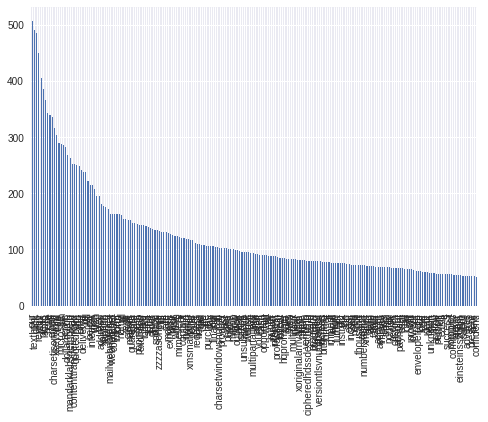

In [22]:
df_trans.index = [x[:20] for x in df_trans.index]
df_trans.sort_values(by='difference',ascending=False).iloc[:200,2].plot.bar()

In [189]:
df_trans.head()

,mean_when_y_is_zero,mean_when_y_is_one,difference,mean_y_col_is_zero,mean_y_col_is_one,difference_in_y_means
words,,,,,,
a,0.826790,0.780411,-0.046380,0.364192,0.298971,-0.065221
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,0.000000,0.002106,0.002106,0.310758,1.000000,0.689242
abil,0.030454,0.035282,0.004827,0.310141,0.343590,0.033449
abl,0.063764,0.066351,0.002587,0.310617,0.319797,0.009180
about,0.327385,0.233281,-0.094105,0.339949,0.243540,-0.096408


In [190]:
df['dep_categorical'] = ['no' if x == 0 else 'spam' for x in df.dependent_variable]
df.dep_categorical = df.dep_categorical.astype('category')

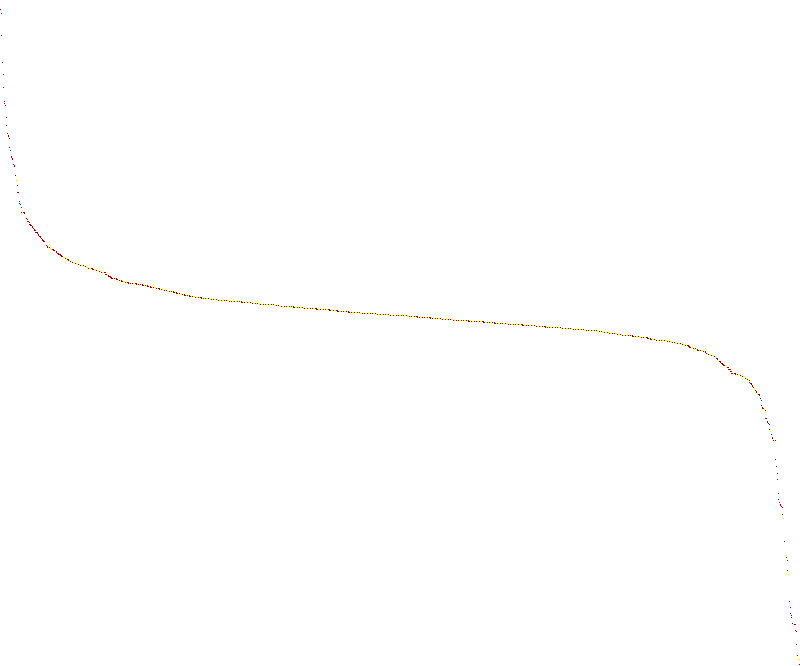

In [194]:
canvas = ds.Canvas(plot_width=800, plot_height=800//1.2)
tf = canvas.points(df_trans.sort_values(by='difference',ascending=False).reset_index(level=0).reset_index(level=0),
                   'index', 'difference')

b = ds.transfer_functions.dynspread(ds.transfer_functions.shade(tf,cmap=["darkred", "yellow"]),threshold=0.1)
b

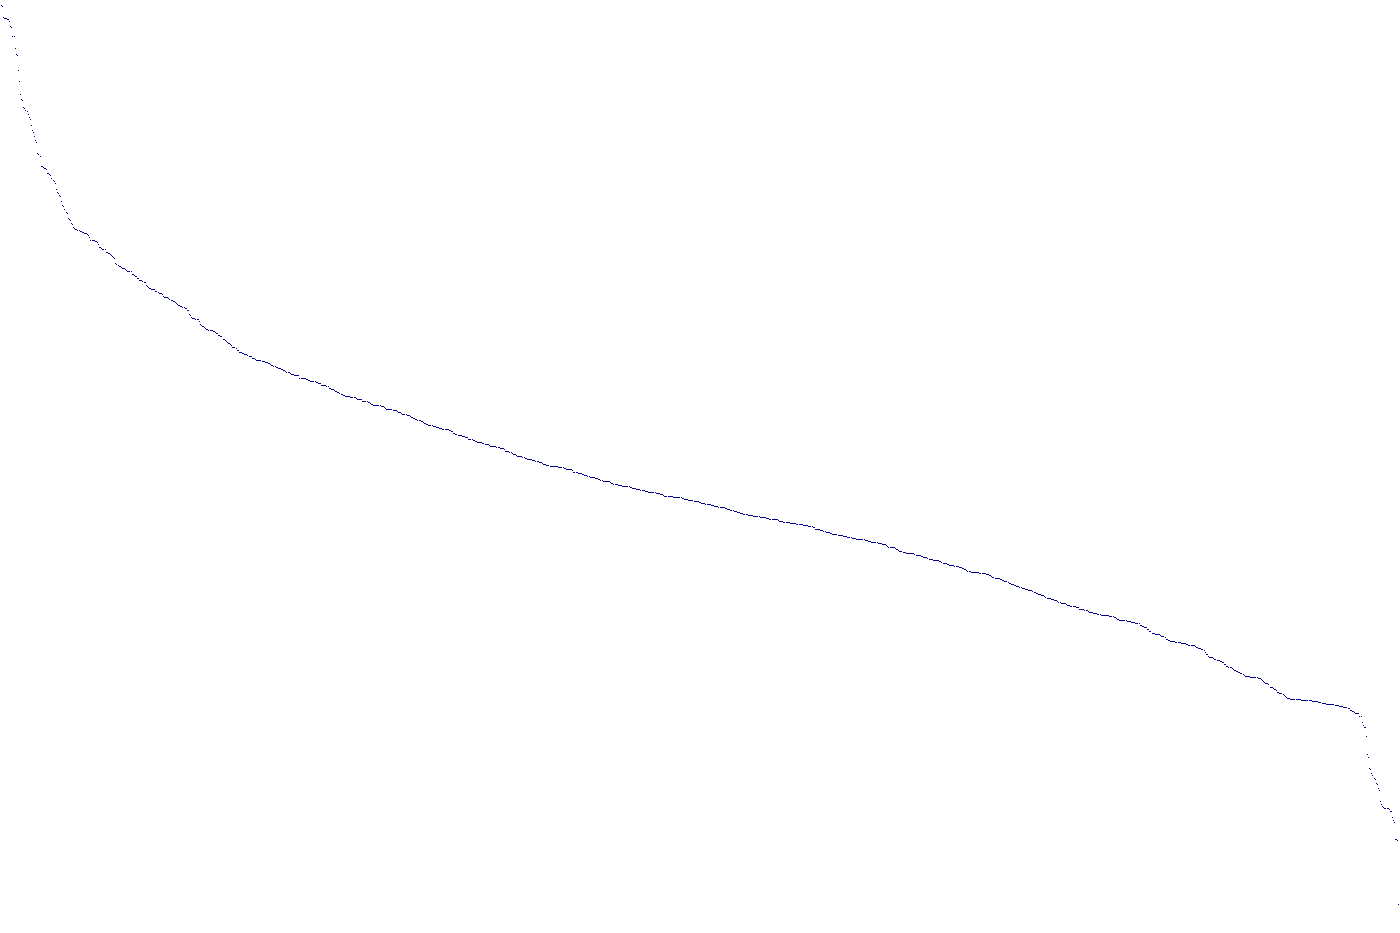

In [360]:
canvas = ds.Canvas(plot_width=800, plot_height=800//1.2)
tf = canvas.points(df_trans.sort_values(by='difference_in_y_means',ascending=False).reset_index(level=0).reset_index(level=0),
                   'index', 'difference_in_y_means')

b = ds.transfer_functions.dynspread(ds.transfer_functions.shade(tf),threshold=0.1)
b
plot_datashader(df_trans.sort_values(by='difference_in_y_means',ascending=False).reset_index(level=0).reset_index(level=0),
               'index','difference_in_y_means',
               spread=False, threshold=0.1)

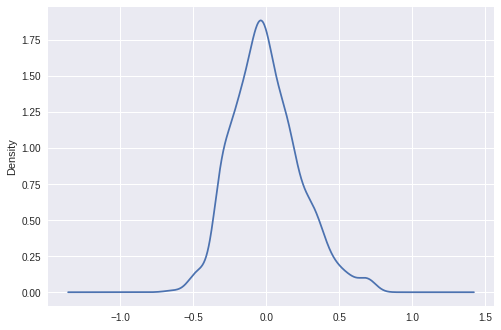

In [196]:
pl = df_trans.sort_values(by='difference_in_y_means',ascending=False).difference_in_y_means.plot
pl.density()

In [290]:
from bokeh.palettes import Inferno

In [371]:
def plot_datashader(df,x,y,aggr=ds.reductions.count(),spread=False,
                    x_range=None,y_range=None, how='eq_hist',
                    plot_width=1400, plot_height=1400//1.5,
                    back_color=None,cmap=['lightblue', 'darkblue'],
                   threshold=0.5):
    if x_range:
        x_range = (df[x].describe(percentiles=[0.05]).loc['5%'],df[x].describe(percentiles=[0.95]).loc['95%'])
    if y_range:
        y_range = (df[y].describe(percentiles=[0.05]).loc['5%'],df[y].describe(percentiles=[0.95]).loc['95%'])
    canvas = ds.Canvas(plot_width=plot_width, plot_height=plot_height,
                      x_range=x_range,
                      y_range=y_range)
    tf = canvas.points(df,x,y,agg=aggr)
    tf = ds.transfer_functions.shade(tf,cmap=cmap,how=how)
    if spread:
        tf = ds.transfer_functions.dynspread(tf,threshold=threshold)
    tf=ds.transfer_functions.set_background(tf,color=back_color)
    return tf

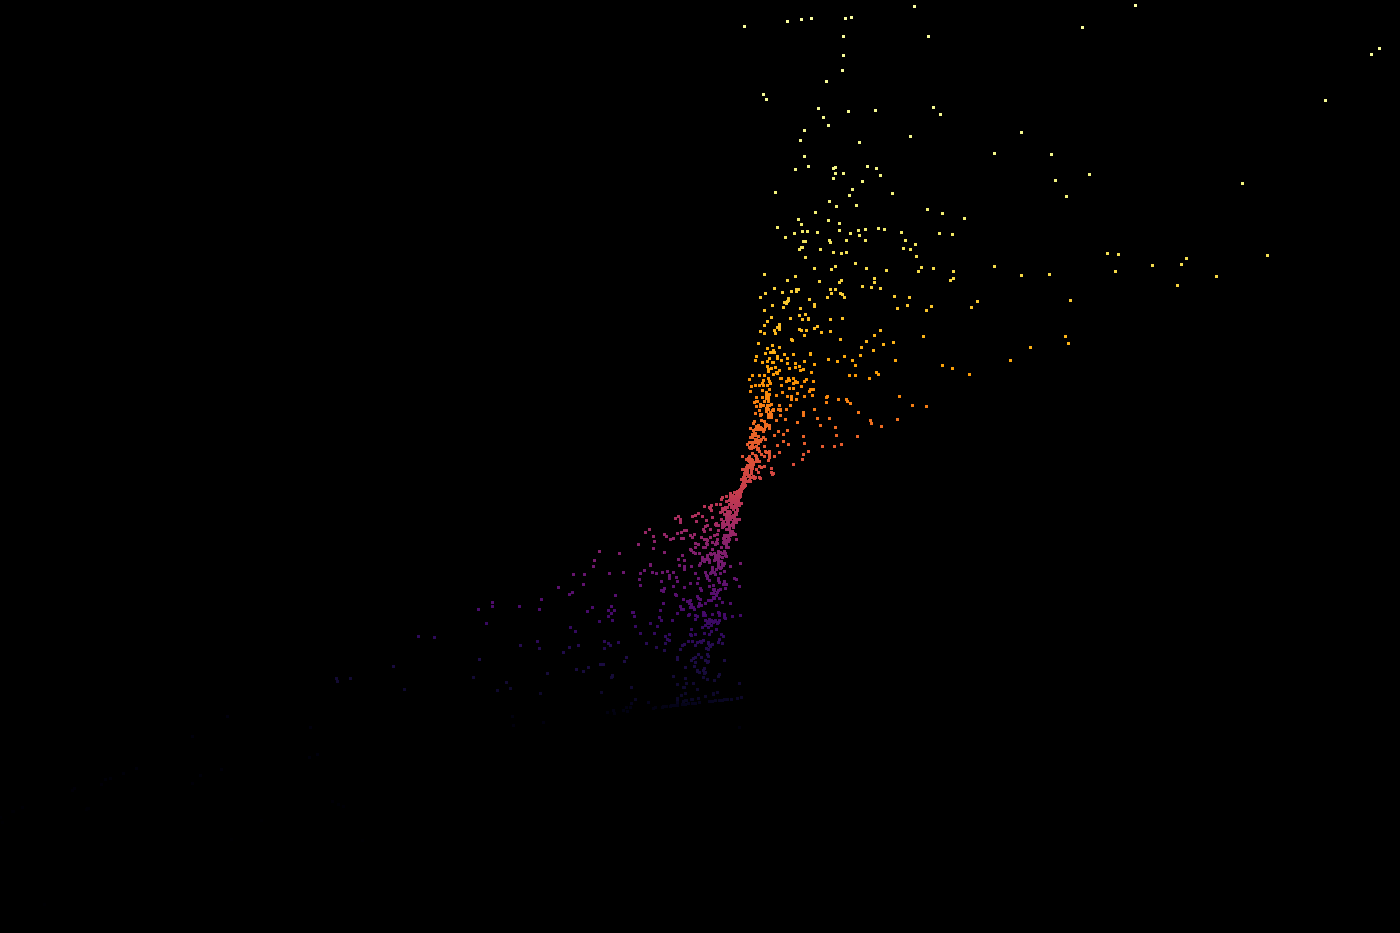

In [374]:
plot_datashader(df_trans.reset_index().reset_index(),
                plot_width=1400, plot_height=1400//1.5,
                x='difference', y='difference_in_y_means',
               aggr=ds.reductions.mean('difference_in_y_means'),
               back_color='black', cmap=Inferno[256],
               spread=True,threshold=0.1)

In [378]:
s = pd.DataFrame(df.mean(axis=1),columns=['mean'])
s['dep'] = df.dependent_variable
s['dep_cat'] = df.dep_categorical

canvas = ds.Canvas(plot_width=800, plot_height=800//3)
tf = canvas.points(s.reset_index().reset_index(),
                   'index', 'mean',agg=ds.reductions.mean(column='dep')
                  )

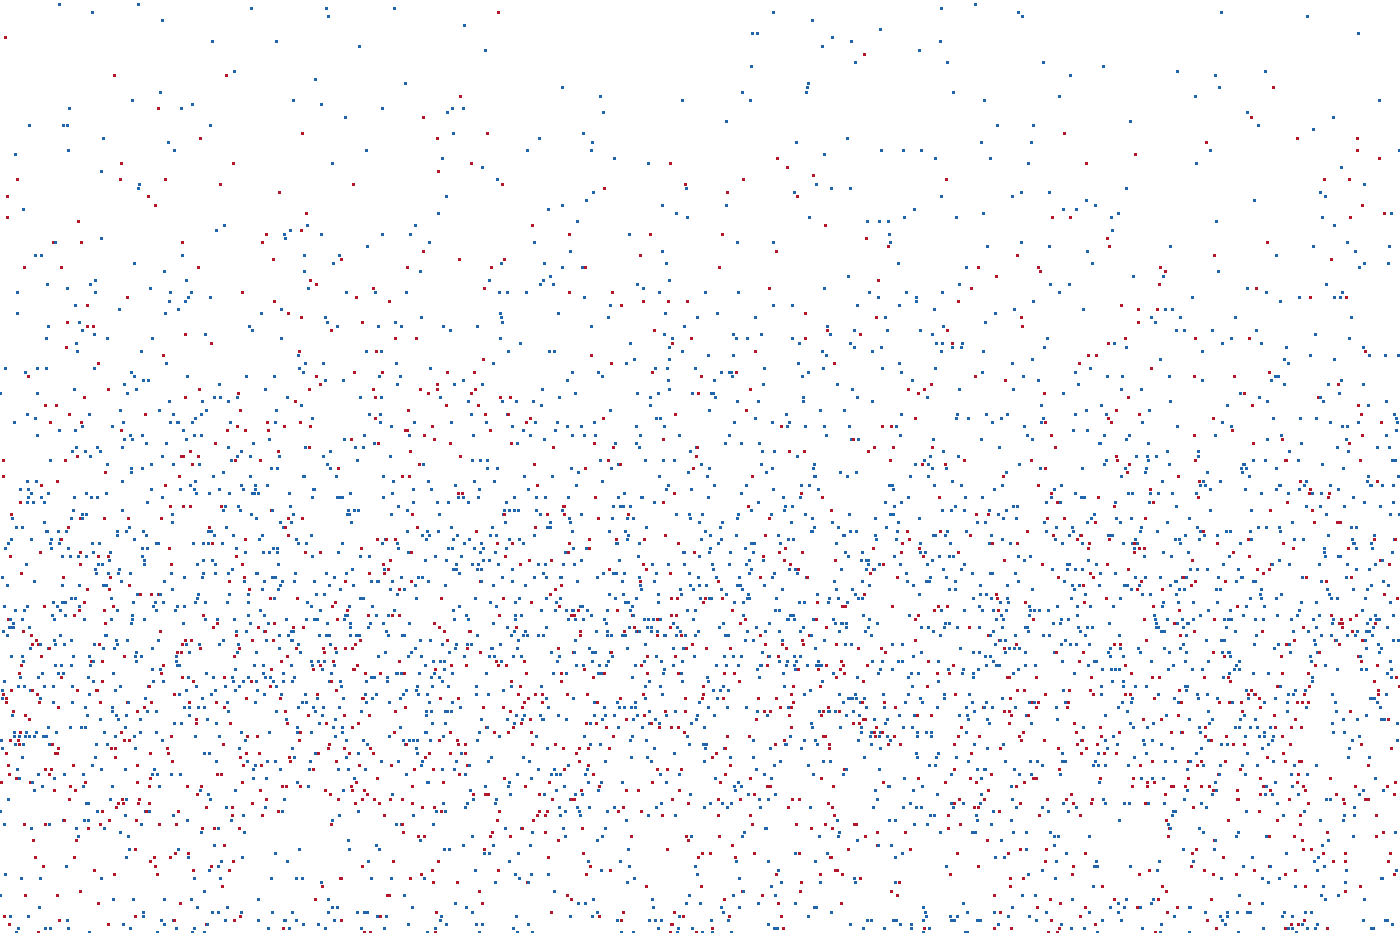

In [389]:
v = plot_datashader(s.reset_index().reset_index(),
                plot_width=1400, plot_height=1400//1.5,
                x='index', y='mean',x_range='a',y_range='f',
               aggr=ds.reductions.mean('dep'),
              spread=True,cmap=RdBu9)
v

In [198]:
canvas = ds.Canvas(plot_width=800, plot_height=800//3)
tf_count = canvas.points(s.reset_index().reset_index(),
                   'index', 'mean',agg=ds.reductions.count_cat('dep_cat')
                  )

In [226]:
v = df_trans.reset_index().reset_index()
canvas = ds.Canvas(plot_width=800, plot_height=800//1.5)
tf_diff = canvas.points(v,
                   'difference', 'difference_in_y_means'
                  )

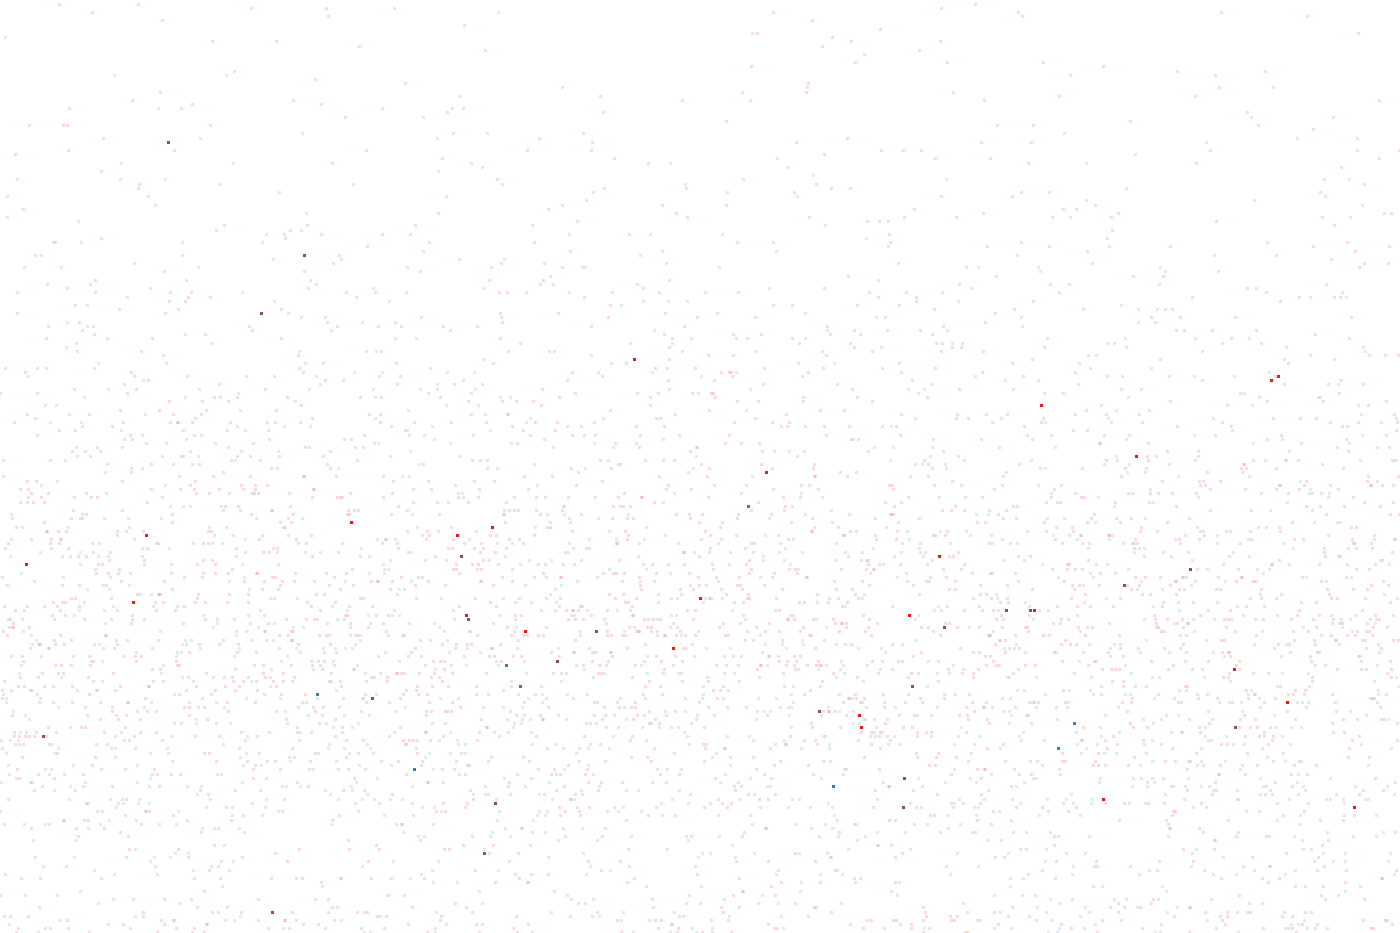

In [391]:
canvas = ds.Canvas(plot_width=800, plot_height=800//3)
tf_count = canvas.points(s.reset_index().reset_index(),
                   'index', 'mean',agg=ds.reductions.count_cat('dep_cat')
                  )
plot_datashader(s.reset_index().reset_index(),
                plot_width=1400, plot_height=1400//1.5,
                x='index', y='mean', x_range='a', y_range='a',
               aggr=ds.reductions.count_cat('dep_cat'),
               spread=True,threshold=0.3)

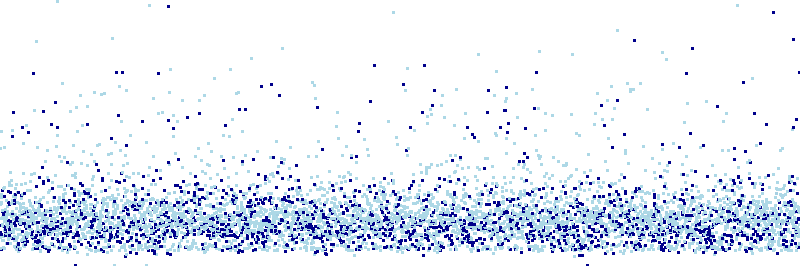

In [201]:
ds.transfer_functions.spread(ds.transfer_functions.shade(tf))

In [206]:
df_trans.difference.describe(percentiles=[0.05,0.95])

count    1294.000000
mean       -0.006898
std         0.105195
min        -0.570599
5%         -0.134231
50%        -0.003705
95%         0.123942
max         0.506836
Name: difference, dtype: float64

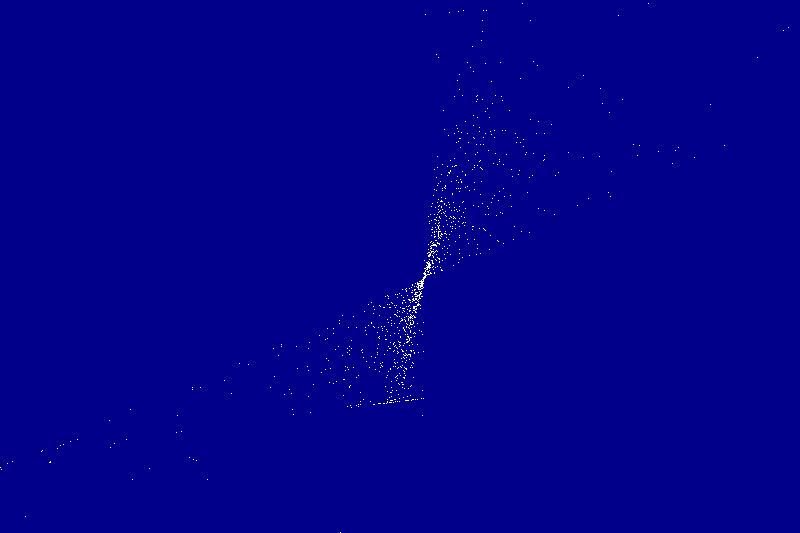

In [232]:
v = ds.transfer_functions.shade(tf_diff.where(np.percentile(tf_diff,0.05)<=tf_diff).where(tf_diff<=np.percentile(tf_diff,0.95)))
v

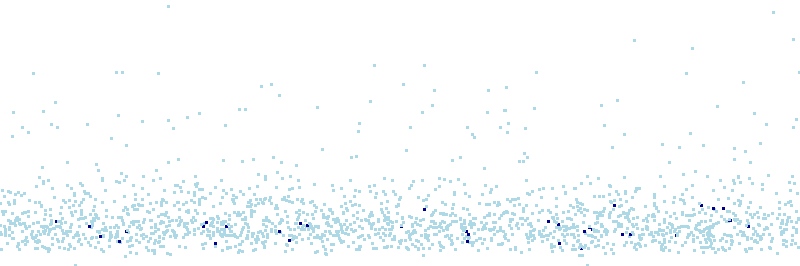

In [147]:
tf_count
ds.transfer_functions.dynspread(ds.transfer_functions.shade(tf_count.sel(dep_cat='spam')),threshold=0.04)
#ds.transfer_functions.shade(tf.where(tf>=np.percentile(tf,99)))

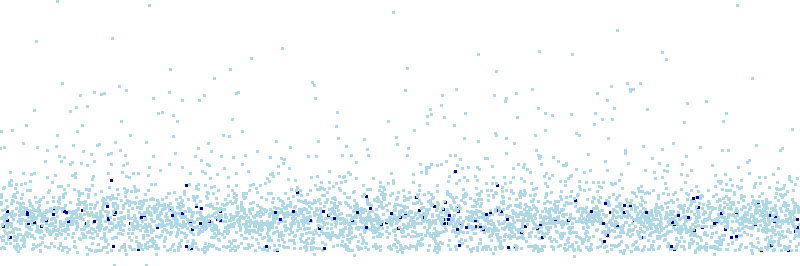

In [153]:
ds.transfer_functions.dynspread(ds.transfer_functions.shade(tf_count.sel(dep_cat='no')),threshold=0.08)

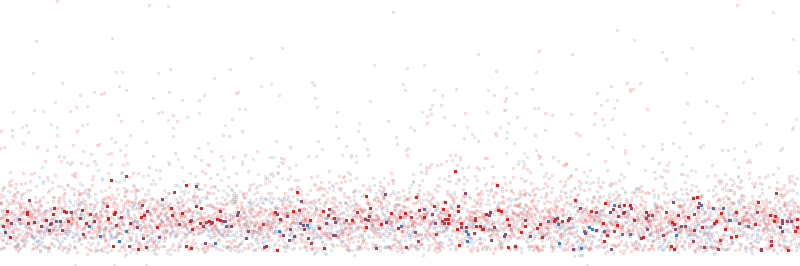

In [154]:
ds.transfer_functions.spread(ds.transfer_functions.shade(tf_count))

In [21]:
count_by_word = pd.DataFrame(df.T.groupby(axis=1),columns=['Total_count']).reset_index(level=0)